In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
from IPython.display import SVG
!python --version

#tensorflow.keras.models for NN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
print(tf.__version__)

#sklearn for data preprocess
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
#matplotlib for ploting
import matplotlib.pyplot as plt
%matplotlib inline 
##able to display plots in colab notebook

#RDKit for Smile datatype preprocess
!pip install rdkit-pypi -qqq
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D

#Allow this colab Notebook to Access files from personal google-drive (e.g.,"/content/drive/MyDrive/"=Home directory of personal google-drive)
import os
from google.colab import drive
drive.mount('/content/drive')
data_directory = os.path.join("/content/drive/MyDrive/")

Python 3.9.16
2.11.0
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#load data from xlsx file stored in personal google-drive
data= pd.read_excel("/content/drive/MyDrive/ColabNotebooks/Colab_Notebooks/mGlu/sample01.xlsx")
df = data
print(df.shape)
#df.head()

(660, 24)


In [5]:
#create RDKit "MOL" data type from SMILES data type, and append "MOL" column in the end. 
df["MOL"] = df["SMILES"].apply(Chem.MolFromSmiles)
#display(df["MOL"][66])
#df["MOL"].head()
#Check the shape of dataframe
print(df.shape)

(660, 25)


In [6]:
# define function of "chemcepterize_mol()" to convert "MOL" type data into chemcepterized feature
##https://www.cheminformania.com/learn-how-to-teach-your-computer-to-see-chemistry-free-chemception-models-with-rdkit-and-keras/
def chemcepterize_mol(mol, embed=12.0, res=0.50):
    dims = int(embed*2/res)
    cmol = Chem.Mol(mol.ToBinary())
    cmol.ComputeGasteigerCharges()
    AllChem.Compute2DCoords(cmol)
    coords = cmol.GetConformer(0).GetPositions()
    vect = np.zeros((dims,dims,4))
    #Bonds first
    for i,bond in enumerate(mol.GetBonds()):
        bondorder = bond.GetBondTypeAsDouble()
        bidx = bond.GetBeginAtomIdx()
        eidx = bond.GetEndAtomIdx()
        bcoords = coords[bidx]
        ecoords = coords[eidx]
        frac = np.linspace(0,1,int(1/res*2))
        for f in frac:
            c = (f*bcoords + (1-f)*ecoords)
            idx = int(round((c[0] + embed)/res))
            idy = int(round((c[1]+ embed)/res))
            #Save in the vector first channel
            vect[ idx , idy ,0] = bondorder
    #Atom Layers
    for i,atom in enumerate(cmol.GetAtoms()):
        idx = int(round((coords[i][0] + embed)/res))
        idy = int(round((coords[i][1]+ embed)/res))
        #Atomic number
        vect[ idx , idy, 1] = atom.GetAtomicNum()
        #Gasteiger Charges
        charge = atom.GetProp("_GasteigerCharge")
        vect[ idx , idy, 3] = charge
        #Hybridization
        hyptype = atom.GetHybridization().real
        vect[ idx , idy, 2] = hyptype
    return vect

In [7]:
#vectorize (iterate and arrange in order) whole molecules of "MOL" type into chemcepterized feature ""molimage"", and append ""molimage"" column in the end of df dataframe.
def vectorize(mol):
    return chemcepterize_mol(mol, embed=12)
df["molimage"] = df["MOL"].apply(vectorize)

In [8]:
print(df.shape)

(660, 26)


In [11]:
Imagesize = 96 #play around the meth, just make sure the Inputs[0]=660=total sample number.
#prepare inputs from df dataframe
Inputs = np.array(list(data["molimage"])).reshape(-1, Imagesize * Imagesize * 1).astype("float32")
print(Inputs.shape)

(660, 9216)


In [13]:
#With this function we pop out 'norm_of_log'(y1=output0) and 'ReceptorBinarized'(y2=output1) two columns from x dataframe(e.g., "df").
def labeled(df):
    y1 = df.pop('norm_mol_feature')
    y1 = np.array(y1)
    y2 = df.pop('BinaryReceptorType')
    y2 = np.array(y2)
    return (y1, y2)
Outputs= labeled(df)

In [16]:
print(len(Outputs)) # Outputs became tuple type with y1 and y2.

2


In [18]:
# prepare Inputs and Outputs for K-fold cross validation, and set/train/test model(randomized initialweights) inside the for-loop. 
import pandas
import os
import glob

appended_data = []

num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=False)
ID_Inp = np.array(range(660)) # total sample number = 660
ID_Out = np.array(range(660))

for IDs_Train, IDs_Test in kfold.split(ID_Inp, ID_Out):
  Fold_Train_Input = Inputs[IDs_Train]
  Fold_Train_OutPut0, Fold_Train_OutPut1 = Outputs[0][IDs_Train], Outputs[1][IDs_Train]

  Fold_Test_Input = Inputs[IDs_Test]
  Fold_Test_OutPut0, Fold_Test_OutPut1 = Outputs[0][IDs_Test], Outputs[1][IDs_Test]

  #combined the inputs and outputs for train and test dataset
  Fold_Train_InputTotal = Fold_Train_Input
  Fold_Train_OutPutTotal = Fold_Train_OutPut0, Fold_Train_OutPut1

  Fold_Test_InputTotal = Fold_Test_Input
  Fold_Test_OutPutTotal = Outputs[0][IDs_Test], Outputs[1][IDs_Test]
  
  
  #====================================================================================
  #setup model 
  inputs = tf.keras.layers.Input(shape=Inputs.shape[1])

  #Add dense layers to the input layer. These layers are commom to both predicted variables. 
  x = Dense(units=32,kernel_initializer='random_normal', activation='relu')(inputs)
  x = Dense(units=32,kernel_initializer='random_normal', activation='relu')(x)
  x = Dense(units=64,kernel_initializer='random_normal', activation='relu')(x)
  x = Dense(units=64,kernel_initializer='random_normal', activation='relu')(x)
  x = Dense(units=128,kernel_initializer='random_normal', activation='relu')(x)
  x = Dense(units=128,kernel_initializer='random_normal', activation='relu')(x)
  
  #add branch1: Output0 layer(y1) as BinaryReceptorType_layer using Sigmoid activation for binary classification task. 
  BinaryReceptorType_layer = Dense(units = 1,kernel_initializer='random_normal', activation='sigmoid', name='BinaryReceptorType_layer')(x)

  #add branch2: Output1 layer(y2) as norm_mol_feature_layrer using relu activation for numerical prediction task.
  norm_mol_feature_layrer01 =Dense(units=64,kernel_initializer='random_normal', name='norm_mol_feature_layrer01', activation='relu')(x)
  norm_mol_feature_layrer = Dense(units=1,kernel_initializer='random_normal', name='norm_mol_feature_layrer')(norm_mol_feature_layrer01)

  #assign one input and two outputs into "model" by Model() function. 
  model = Model(inputs=inputs, outputs=[norm_mol_feature_layrer, BinaryReceptorType_layer])

  #set optimizers 
  optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
  #optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)


  #To compile the model we use two dictionaries, to indicate the loss functions and metrics  
  model.compile(optimizer=optimizer, 
                loss = {'BinaryReceptorType_layer' : 'binary_crossentropy', 
                        'norm_mol_feature_layrer' : 'mse'
                      },
                metrics = {'BinaryReceptorType_layer' : 'accuracy', 
                          'norm_mol_feature_layrer': tf.keras.metrics.RootMeanSquaredError()
                        }
              )
  #====================================================================================
  #trian and test the model for 5 repeats (K-fold cross validation) with randomized initial weights.
  history = model.fit(Fold_Train_InputTotal, Fold_Train_OutPutTotal, 
                    epochs =100,batch_size=50, shuffle=True, validation_data=(Fold_Test_InputTotal, Fold_Test_OutPutTotal))
  loss,  norm_loss, rec_type_loss, norm_rmse, rec_type_accuracy = model.evaluate(x=Fold_Test_InputTotal, y=Fold_Test_OutPutTotal)

  print()
  print("Test Results from K-fold cross validation")
  print(f'loss: {loss}')
  print(f'norm_loss: {norm_loss}')
  print(f'rec_type_loss: {rec_type_loss}')
  print(f'norm_rmse: {norm_rmse}')
  print(f'rec_accuracy: {rec_type_accuracy}')
  print("\n")
  print("\n")
  print("\n")
  print("\n")
  print("\n")

Epoch 1/100
11/11 [==============================] - 2s 45ms/step - loss: 1.2090 - norm_mol_feature_layrer_loss: 0.5159 - BinaryReceptorType_layer_loss: 0.6930 - norm_mol_feature_layrer_root_mean_squared_error: 0.7183 - BinaryReceptorType_layer_accuracy: 0.5795 - val_loss: 0.8843 - val_norm_mol_feature_layrer_loss: 0.1902 - val_BinaryReceptorType_layer_loss: 0.6941 - val_norm_mol_feature_layrer_root_mean_squared_error: 0.4361 - val_BinaryReceptorType_layer_accuracy: 0.0000e+00
Epoch 2/100
11/11 [==============================] - 0s 14ms/step - loss: 1.2006 - norm_mol_feature_layrer_loss: 0.5077 - BinaryReceptorType_layer_loss: 0.6929 - norm_mol_feature_layrer_root_mean_squared_error: 0.7126 - BinaryReceptorType_layer_accuracy: 0.5852 - val_loss: 0.8803 - val_norm_mol_feature_layrer_loss: 0.1856 - val_BinaryReceptorType_layer_loss: 0.6947 - val_norm_mol_feature_layrer_root_mean_squared_error: 0.4308 - val_BinaryReceptorType_layer_accuracy: 0.0000e+00
Epoch 3/100
11/11 [=================

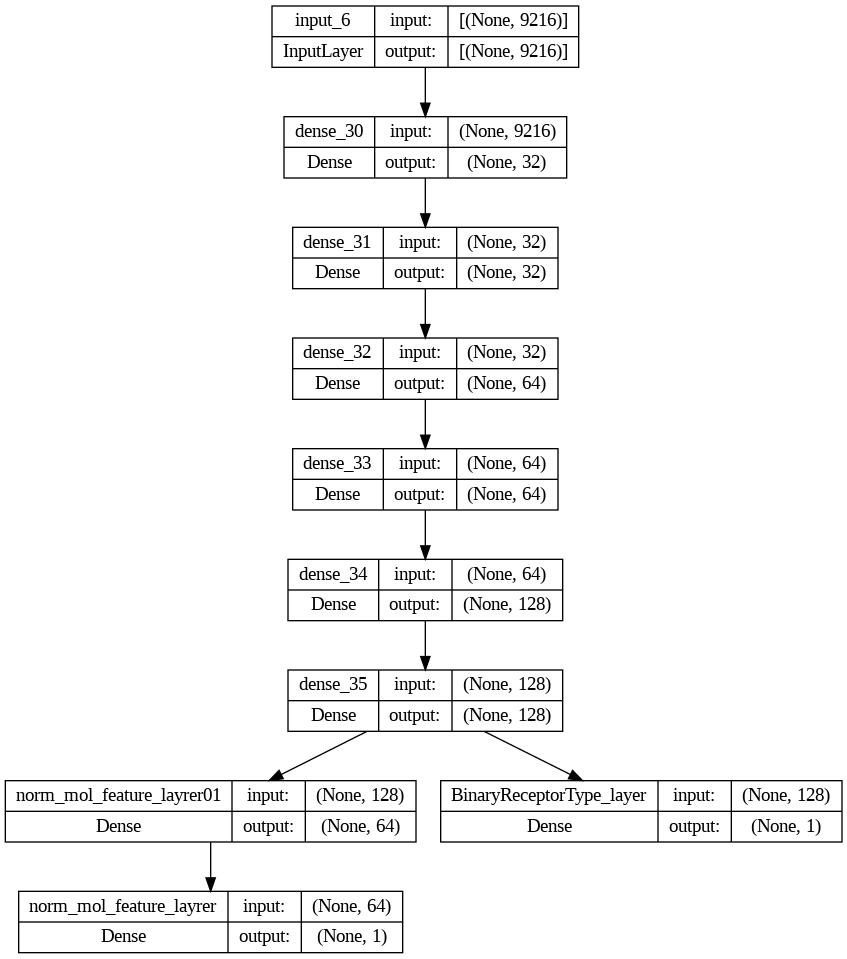

In [19]:
#check model structure
tf.keras.utils.plot_model(model, "multi.png", show_shapes=True)

In [20]:
#check model parametters
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 9216)]       0           []                               
                                                                                                  
 dense_30 (Dense)               (None, 32)           294944      ['input_6[0][0]']                
                                                                                                  
 dense_31 (Dense)               (None, 32)           1056        ['dense_30[0][0]']               
                                                                                                  
 dense_32 (Dense)               (None, 64)           2112        ['dense_31[0][0]']               
                                                                                            